In [1]:
import pandas as pd
import numpy as np
import configparser
config = configparser.ConfigParser()

config.read("../final_project_files/env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [2]:
OHCO = ['book_title','chap_num', 'para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)

In [3]:
CORPUS = pd.read_csv(f"{output_dir}\\CORPUS.csv").set_index(OHCO)
CORPUS.head()

token_str term_str  \
book_title           chap_num para_num sent_num token_num                      
01_a_game_of_thrones 1        0        1        1                We       we   
                                                2            should   should   
                                                3             start    start   
                                                4              back     back   
                                                7             Gared    gared   

                                                           pos pos_group  
book_title           chap_num para_num sent_num token_num                 
01_a_game_of_thrones 1        0        1        1          PRP        PR  
                                                2           MD        MD  
                                                3           VB        VB  
                                                4           RP        RP  
                                                7          VBD        VB

### BOW

In [4]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

### TFIDF

In [5]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF, DTCM

### Using Fuctions

In [6]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['max_pos'] = CORPUS.value_counts(['term_str','pos']).unstack().idxmax(1)
VOCAB.head()

,n,max_pos
term_str,,
the,157912,DT
and,74625,CC
to,65973,TO
a,62275,DT
of,56741,IN


In [7]:
bag = bags['BOOKS']
BOW = create_bow(CORPUS, bag)
TFIDF, DFIDF, DTM = get_tfidf(BOW, tf_method='log', df_method='sklearn_smooth')

In [8]:
VOCAB['dfidf'] = DFIDF
VOCAB['mean_tfidf'] = TFIDF.mean()

In [9]:
VOCAB.head(2)

,n,max_pos,dfidf,mean_tfidf
term_str,,,,
the,157912,DT,18.0,12.667895
and,74625,CC,18.0,11.492454


In [10]:
TFIDF[VOCAB.sort_values('n', ascending=False).head(200).sample(10).index].sample(10).fillna(0).style.background_gradient(cmap='GnBu', high=.75)

term_str,one,more,every,made,again,would,re,still,something,jon
book_title,,,,,,,,,,
01_a_game_of_thrones,9.631177,8.897845,7.483816,8.499846,8.129283,10.134426,7.417853,8.321928,6.930737,25.794812
07_the_fire_ascending,8.499846,7.330917,6.044394,7.159871,7.845490,8.082149,6.820179,6.845490,6.686501,0.000000
04_rising_storm,6.741467,6.965784,5.000000,6.285402,6.129283,7.665336,6.321928,6.918863,5.459432,0.000000
06_fire_world,8.588715,7.169925,5.643856,7.139551,7.348728,7.857981,7.636625,6.643856,7.562242,0.000000
04_fire_star,7.906891,7.000000,5.781360,6.491853,7.357552,7.523562,7.475733,6.189825,7.000000,0.000000
06_the_darkest_hour,7.011227,6.977280,6.129283,5.672425,6.930737,8.243174,7.257388,6.954196,5.700440,0.000000
03_forest_of_secrets,6.918863,7.000000,5.523562,6.108524,7.044394,7.918863,6.870365,6.569856,5.807355,0.000000
05_a_dance_with_dragons,10.704768,9.820179,8.665336,9.287712,8.848623,10.814582,7.499846,9.111136,7.209453,25.990241
01_into_the_wild,7.149747,6.554589,4.392317,5.977280,6.066089,7.011227,6.022368,6.882643,5.523562,0.000000


In [11]:
bag2 = bags['CHAPS']
BOW2 = create_bow(CORPUS, bag2)
TFIDF2, DFIDF2, DTM2 = get_tfidf(BOW2, tf_method='log', df_method='sklearn_smooth')

In [12]:
VOCAB2 = VOCAB.copy()
VOCAB2['dfidf'] = DFIDF2
VOCAB2['mean_tfidf'] = TFIDF2.mean()

In [13]:
TFIDF2.head()

term_str                         0  031  032    1   10  100  101  102  103  \
book_title           chap_num                                                
01_a_game_of_thrones 1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     2         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

term_str                       104  ...  zoomed  zooming  zorse  zorses   zz  \
book_title           chap_num       ...                                        
01_a_game_of_thrones 1         0.0  ...     0.0      0.0    0.0     0.0  0.0   
                     2         0.0  ...     0.0      0.0    0.0     0.0  0.0   
                     3         0.0  ...     0.0      0.0    0.0     0.0  0.0   
                     4         0.0  ...     0.0      0.0    0.0     0.0  0.0   
                     5         0.0  ...     0.0      0.0    0.0     0.0  0.0   

term_str                       zzed  zzing  zzle  zzled  zzzs  
book_title           chap_num                                  
01_a_game_of_thrones 1          0.0    0.0   0.0    0.0   0.0  
                     2          0.0    0.0   0.0    0.0   0.0  
                     3          0.0    0.0   0.0    0.0   0.0  
                     4          0.0    0.0   0.0    0.0   0.0  
                     5          0.0    0.0   0.0    0.0   0.0  

[5 rows x 34786 columns]

In [14]:
TFIDF2[VOCAB2.sort_values('n', ascending=False).head(200).sample(10).index].sample(10).fillna(0).style.background_gradient(cmap='GnBu', high=.75)

In [15]:
VOCAB.to_csv(f"{output_dir}\\BOW_books.csv")
VOCAB2.to_csv(f"{output_dir}\\BOW_chaps.csv")

TFIDF.to_csv(f"{output_dir}\\TFIDF_books.csv")
TFIDF2.to_csv(f"{output_dir}\\TFIDF_chaps.csv")

DTM.to_csv(f"{output_dir}\\DTM_books.csv")
DTM2.to_csv(f"{output_dir}\\DTM_chaps.csv")

### Reduce and Normalize TFIDF with L2

In [16]:
from numpy.linalg import norm
from scipy.spatial.distance import pdist

In [17]:
VOCAB.dfidf.sort_values(ascending=False)

term_str
singing         18.774517
overwhelmed     18.774517
strongly        18.774517
merely          18.774517
glistened       18.774517
                  ...    
creatively       4.247928
experiments      4.247928
ceremonial       4.247928
combinations     4.247928
eros             4.247928
Name: dfidf, Length: 34786, dtype: float64

In [18]:
VOCAB2.dfidf.sort_values(ascending=False).head(10)

term_str
put        887.012822
old        887.009704
much       887.008116
moment     887.001873
heard      887.001873
called     886.996416
himself    886.993300
don        886.953633
ve         886.953633
side       886.941520
Name: dfidf, dtype: float64

In [19]:
n_terms = 1000
pos_list = [
    'JJ',  # Adjective
    'JJR', # Comparative adjective
    'JJS', # Superlative adjective
    'VB',  # Verb, base form
    'VBD', # Verb, past tense
    'VBG', # Verb, gerund/present participle
    'VBN', # Verb, past participle
    'VBP', # Verb, non-3rd person singular present
    'VBZ', # Verb, 3rd person singular present
    'NNS'  # Plural noun
]

In [20]:
VIDX = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]\
    .sort_values('dfidf', ascending=False)\
    .head(n_terms).index
VIDX2 = VOCAB2.loc[VOCAB2.max_pos.isin(pos_list)]\
    .sort_values('dfidf', ascending=False)\
    .head(n_terms).index

In [21]:
M = TFIDF[VIDX].fillna(0).groupby('book_title').mean() # MUST FILLNA
M2 = TFIDF2[VIDX2].fillna(0).groupby(['book_title', 'chap_num']).mean()
M.head()

term_str,movements,lighter,personal,forming,cracking,noble,concerns,finished,giant,heaving,...,crush,divided,snatch,fright,cracks,crumpled,unseen,scratches,whipping,shoes
book_title,,,,,,,,,,,,,,,,,,,,,
01_a_game_of_thrones,3.113791,2.682074,3.466530,1.341037,3.113791,6.303463,2.682074,6.376480,6.066264,2.682074,...,2.45271,2.452710,2.452710,2.452710,3.593155,2.452710,3.593155,3.094976,0.000000,1.547488
01_into_the_wild,0.000000,1.341037,0.000000,1.341037,3.466530,2.682074,1.341037,5.890260,0.000000,2.125493,...,0.00000,0.000000,1.547488,0.000000,0.000000,0.000000,1.547488,4.000198,0.000000,0.000000
01_the_fire_within,1.341037,1.341037,2.125493,2.125493,2.125493,0.000000,0.000000,1.341037,1.341037,1.341037,...,0.00000,0.000000,0.000000,3.094976,1.547488,3.094976,0.000000,0.000000,0.000000,3.593155
02_a_clash_of_kings,1.341037,2.682074,2.125493,2.125493,1.341037,4.962426,3.113791,6.066264,6.148604,1.341037,...,2.45271,4.000198,1.547488,1.547488,4.905420,0.000000,5.353428,3.593155,1.547488,4.642463
02_fire_and_ice,1.341037,1.341037,0.000000,0.000000,0.000000,0.000000,1.341037,4.639226,1.341037,4.250986,...,0.00000,2.452710,0.000000,1.547488,2.452710,1.547488,0.000000,1.547488,1.547488,0.000000


In [22]:
M2.head()

term_str                            put       old      much     heard  \
book_title           chap_num                                           
01_a_game_of_thrones 1         2.884595  4.333924  1.435288  4.022826   
                     2         3.728284  3.734343  2.274878  3.327229   
                     3         2.285987  4.333924  0.000000  2.271187   
                     4         1.442297  4.997637  2.274878  2.271187   
                     5         2.884595  3.354353  2.274878  0.000000   

term_str                         called       don       get     found  \
book_title           chap_num                                           
01_a_game_of_thrones 1         2.898681  2.847363  1.463531  3.662277   
                     2         2.297150  1.423682  1.463531  3.662277   
                     3         2.297150  0.000000  0.000000  2.245515   
                     4         4.594301  3.680164  2.319642  2.245515   
                     5         1.449341  2.256482  1.463531  1.416762   

term_str                           seen       say  ...    riders    steady  \
book_title           chap_num                      ...                       
01_a_game_of_thrones 1         4.122018  2.238233  ...  0.000000  0.000000   
                     2         2.327189  1.412168  ...  4.079727  0.000000   
                     3         2.936585  1.412168  ...  0.000000  0.000000   
                     4         2.327189  2.824335  ...  0.000000  0.000000   
                     5         3.409270  3.964456  ...  4.079727  4.079727   

term_str                       faced  amber     twins     dried   marched  \
book_title           chap_num                                               
01_a_game_of_thrones 1           0.0    0.0  4.079727  0.000000  0.000000   
                     2           0.0    0.0  0.000000  0.000000  0.000000   
                     3           0.0    0.0  0.000000  4.079727  0.000000   
                     4           0.0    0.0  0.000000  0.000000  0.000000   
                     5           0.0    0.0  0.000000  0.000000  4.079727   

term_str                       chambers  chains  nearby  
book_title           chap_num                            
01_a_game_of_thrones 1              0.0     0.0     0.0  
                     2              0.0     0.0     0.0  
                     3              0.0     0.0     0.0  
                     4              0.0     0.0     0.0  
                     5              0.0     0.0     0.0  

[5 rows x 1000 columns]

In [23]:
L2 = M.apply(lambda x: x / norm(x), 1) # Euclidean
L2_2 = M2.apply(lambda x: x / norm(x), 1) # Euclidean

In [24]:
VSHORT = VOCAB.loc[VIDX]
VSHORT2 = VOCAB.loc[VIDX2]

In [25]:
L2.to_csv(f"{output_dir}\\l2_norm_books.csv")
L2_2.to_csv(f"{output_dir}\\l2_norm_chaps.csv")
VSHORT.to_csv(f"{output_dir}\\VSHORT_books.csv")
VSHORT2.to_csv(f"{output_dir}\\VSHORT_chaps.csv")

In [26]:
M.T.corr().stack().to_frame('correl')

correl
book_title            book_title                     
01_a_game_of_thrones  01_a_game_of_thrones   1.000000
                      01_into_the_wild       0.016468
                      01_the_fire_within     0.089745
                      02_a_clash_of_kings    0.773487
                      02_fire_and_ice       -0.030038
...                                               ...
07_the_fire_ascending 05_a_dangerous_path   -0.058081
                      05_dark_fire           0.387336
                      06_fire_world          0.511747
                      06_the_darkest_hour   -0.056117
                      07_the_fire_ascending  1.000000

[324 rows x 1 columns]

In [27]:
PAIRS = M.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

In [28]:
general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median
combos  = [
    (L2, 'euclidean', 'euclidean-ward', 'ward'),
    (L2,  'euclidean', 'euclidean-centroid', 'centroid'),
    (L2,  'euclidean', 'euclidean-median', 'median')
]

In [29]:
for X, metric, label, _ in combos:
    PAIRS[label] = pdist(X, metric)

In [30]:
PAIRS.style.background_gradient('GnBu', high=.5)

### Visualizations: Trees

In [31]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [32]:
LIB = pd.read_csv(f"{output_dir}\\LIB.csv")

In [33]:
LIB['label'] = LIB.author.str.split(', ').str[0] + ': ' +  LIB.book_title.str[:20] + ' (' + LIB.year.astype('str') + ')'
LIB.set_index('book_title', inplace=True)
LIB.head()

,book_length,n_chaps,series,year,author,label
book_title,,,,,,
01_a_game_of_thrones,297169,73,ASOIAF,1996,George R.R. Martin,George R.R. Martin: 01_a_game_of_thrones (1996)
01_into_the_wild,64386,26,Warrior_Cats,2003,Kate Cary,Kate Cary: 01_into_the_wild (2003)
01_the_fire_within,51223,42,Last_Dragon_Chronicles,2001,Chris D'Lacey,Chris D'Lacey: 01_the_fire_within (2001)
02_a_clash_of_kings,324987,70,ASOIAF,1998,George R.R. Martin,George R.R. Martin: 02_a_clash_of_kings (1998)
02_fire_and_ice,73544,31,Warrior_Cats,2003,Kate Cary,Kate Cary: 02_fire_and_ice (2003)


In [34]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.label.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

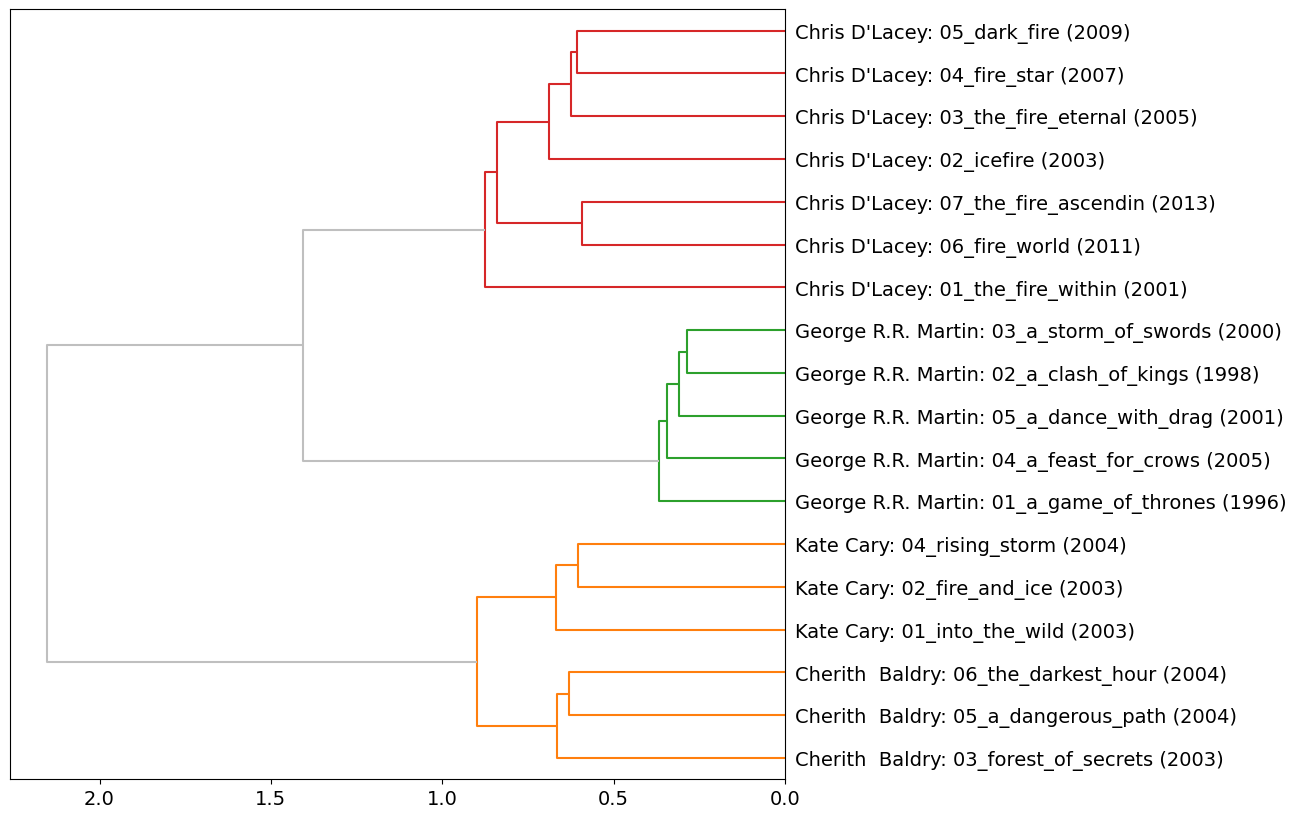

In [35]:
hac(PAIRS['euclidean-ward'], linkage_method='ward', color_thresh=.9)

<Figure size 640x480 with 0 Axes>

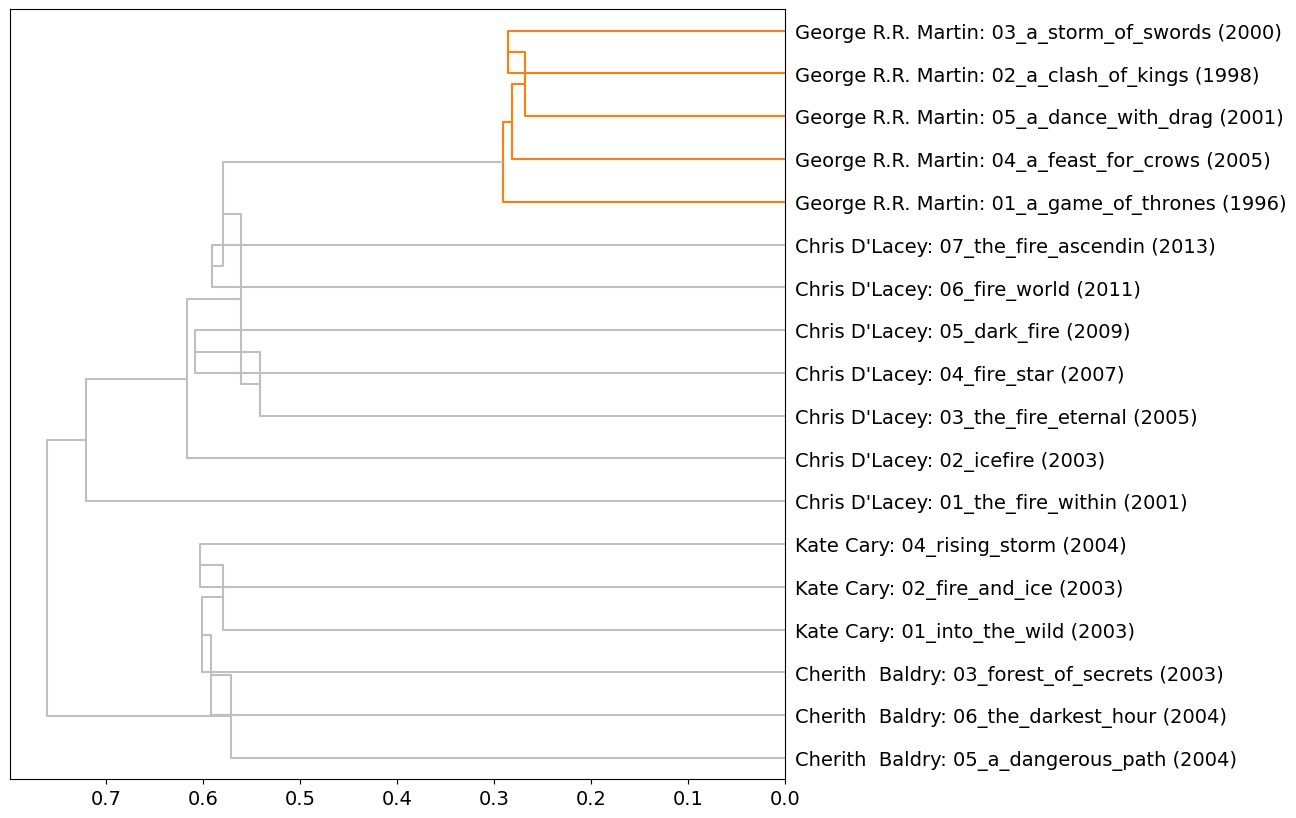

In [36]:
hac(PAIRS['euclidean-centroid'], linkage_method='centroid', color_thresh=.5)

<Figure size 640x480 with 0 Axes>

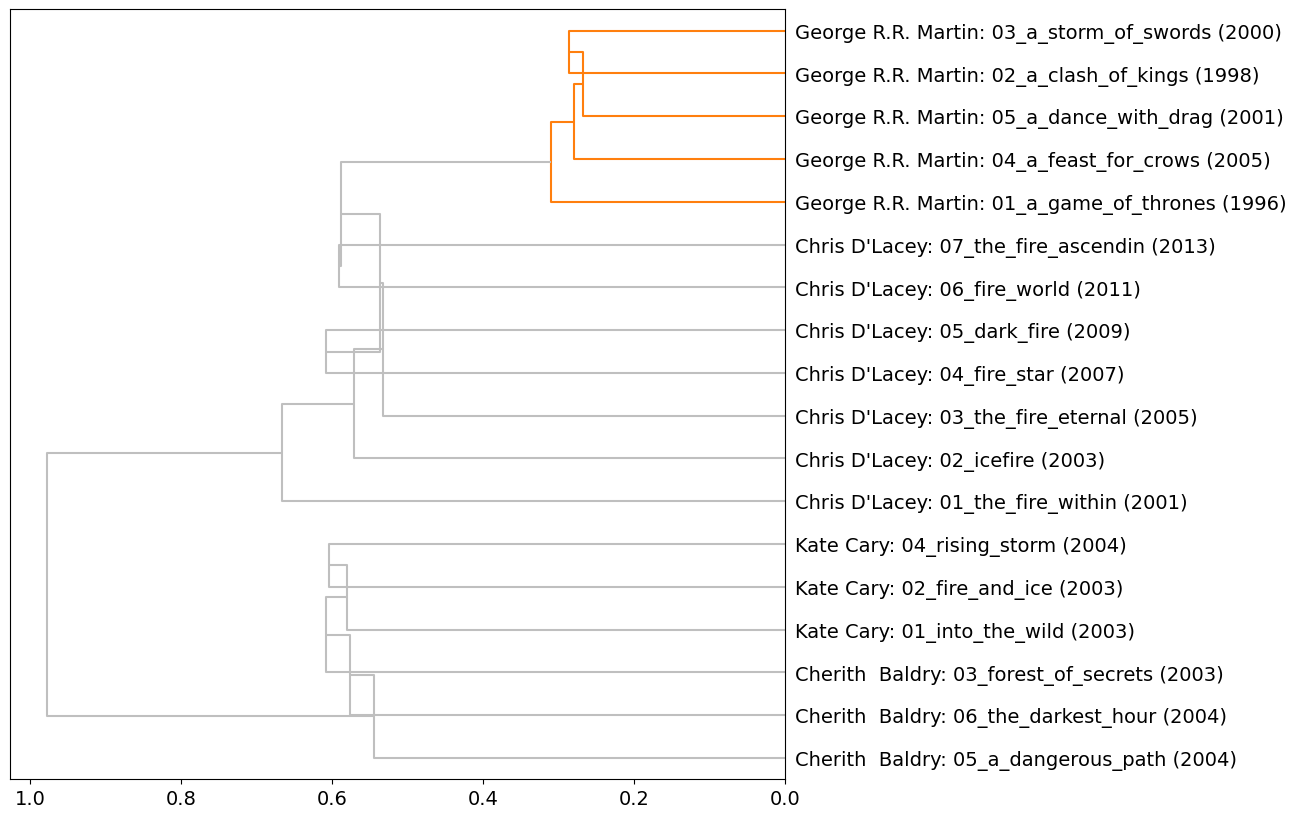

In [37]:
hac(PAIRS['euclidean-median'], linkage_method='median', color_thresh=.5)

### Visualizations: K-Means

In [38]:
from sklearn.cluster import KMeans

In [39]:
def get_k_clusters(k=10, n_init='auto'):
    LIB[f'y_raw_{k}'] = KMeans(k, n_init=n_init).fit_predict(M)
    LIB[f'y_L2_{k}']  = KMeans(k, n_init=n_init).fit_predict(L2)
    y_cols = [col for col in LIB.columns if 'y_' in col and f'_{k}' in col]
    return LIB.reset_index().set_index('label')[y_cols].sort_values('label').style.background_gradient("YlGnBu")

In [40]:
get_k_clusters(3)

,y_raw_3,y_L2_3
label,,
Cherith Baldry: 03_forest_of_secrets (2003),2,1
Cherith Baldry: 05_a_dangerous_path (2004),2,1
Cherith Baldry: 06_the_darkest_hour (2004),2,1
Chris D'Lacey: 01_the_fire_within (2001),0,0
Chris D'Lacey: 02_icefire (2003),0,0
Chris D'Lacey: 03_the_fire_eternal (2005),0,0
Chris D'Lacey: 04_fire_star (2007),0,0
Chris D'Lacey: 05_dark_fire (2009),0,0
Chris D'Lacey: 06_fire_world (2011),0,0


In [41]:
get_k_clusters(4)

,y_raw_4,y_L2_4
label,,
Cherith Baldry: 03_forest_of_secrets (2003),3,1
Cherith Baldry: 05_a_dangerous_path (2004),3,1
Cherith Baldry: 06_the_darkest_hour (2004),3,1
Chris D'Lacey: 01_the_fire_within (2001),2,3
Chris D'Lacey: 02_icefire (2003),2,3
Chris D'Lacey: 03_the_fire_eternal (2005),2,2
Chris D'Lacey: 04_fire_star (2007),2,2
Chris D'Lacey: 05_dark_fire (2009),2,2
Chris D'Lacey: 06_fire_world (2011),2,2


In [42]:
LIB.to_csv(f"{output_dir}\\LIB_LABELS.csv")